<a href="https://colab.research.google.com/github/Simurgh818/BMED8803_Lab6/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: TD-Learning and Multi-armed Bandit
In this lab, you will implement **Temporal-Difference (TD) learning**, a foundational reinforcement learning method that enables an agent to update its reward estimates incrementally based on the difference between predicted and observed rewards. You will apply TD learning in a **Pavlovian conditioning** environment, observing how the agent learns associations over time.

You will also explore the **multi-armed bandit** problem, where an agent repeatedly selects among $ k $ actions, each providing a reward. The goal is to maximize the total reward over a series of selections. In this setup, each action’s reward is drawn from a Gaussian distribution with an unknown mean, creating an environment of uncertainty.

In [1]:
using_colab = True

In [2]:
if using_colab:
    import sys
    from google.colab import drive
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/MyDrive/BMED_8803_tat_Models_for_Neural_Data/lab6')

Mounted at /content/gdrive/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from utils import *
%matplotlib inline

# 1. TD Learning (5 Points)

## 1.1 Introduction of TD Learning

In reinforcement learning, we define the **state value function** $ V(s) $ as the expected return, or cumulative future reward, for being in state $ s $. This value represents the expected reward an agent can receive when starting from state $ s $ and following a particular policy. The purpose of defining $ V(s) $ is to help the agent evaluate states based on their expected long-term reward, guiding its decision-making process.

Mathematically, $ V(s) $ can be expressed as:

$$
V(S_t) = \mathbb{E} \left[ \sum_{i=t+1}^{t_{\text{end}}} \gamma^{i-(t+1)} r(S_i) \right],
$$

where $ \gamma $ is the **discount factor** $ (0 \leq \gamma < 1) $, which controls how much future rewards are weighted relative to immediate rewards. A lower $ \gamma $ places less emphasis on future rewards. This expression can also be rewritten as a recursive formula called the **Bellman equation**:

$$
V(S_t) = \mathbb{E} \left[ r(S_{t+1}) + \gamma V(S_{t+1}) \right],
$$

The Bellman equation is crucial in reinforcement learning because it breaks down the value of the current state $ S_t $ into two parts: the immediate reward $ r(S_{t+1}) $ and the discounted value of the next state $ S_{t+1} $. This recursive formulation allows the agent to build value estimates incrementally, updating $ V(S_t) $ based on subsequent states without needing to calculate the full expected return for every step ahead.

To improve our estimate of $ V(S_t) $ based on observed outcomes, we define the **Temporal-Difference (TD) error**:

$$
\delta_{t+1} = r(S_{t+1}) + \gamma V(S_{t+1}) - V(S_t),
$$

The TD error $ \delta_{t+1} $ measures the difference between the current estimate $ V(S_t) $ and the updated reward based on what was actually observed $ r(S_{t+1}) + \gamma V(S_{t+1}) $. This error term plays a vital role in learning because it quantifies how much the current value estimate needs adjustment.

Finally, we adjust the value function $ V(S_t) $ incrementally using the TD error to refine our estimates in real-time:

$$
V_{\text{new}}(S_t) = V_{\text{old}}(S_t) + \eta \delta_{t+1},
$$

where $\eta$ is the **learning rate**, which controls how much influence the TD error has on the updated value estimate.

All in all, the TD update process allows the agent to correct its value estimates as it experiences new states and rewards, helping it adapt to dynamic environments and become progressively more accurate over time.

## 1.2 Introduction of Pavlovian Conditioning Environment

<center><img src="https://github.com/ZKBig/8803_GMM_Lab3/blob/main/pavlovian_conditioning_env.png?raw=true" width="500" height="320"/></center>
<!-- ![CA1_data](https://drive.google.com/uc?id=1y3QhKffqte7DbZmmXJFt2VC4zjbwrLGD) -->
<center> Figure 1: Process of Pavlovian conditioning experiment. </center>

Pavlovian conditioning is demonstrated a process where a neutral stimulus, like the sound of a bell, could trigger a salivery response in dogs through repeated pairings with food. Specifically, before conditioning, food can naturally cause the dog to salivate, which is an automatic response. Here, **food** is the **unconditioned stimulus (US)**, and **salivation** is the **unconditioned response (UR)**. The bell ringing does not initially cause any salivation, which is simply a neutral sound with no inherent meaning to the dog in this context. It is refered as **Neutral Stimulus (NS)**.

 During conditioning, the dog begins to associate the bell sound with the food, and salivation starts to occur even when the food is not present. Once this kind of association is established, the **bell ringing** becomes a **conditioned stimulus (CS)**. Even in the absence of food, the bell alone can trigger **salivation**, which is now referred to as the **conditioned response (CR)**.

 By applying TD learning to this Pavlovian conditioning setup, we allow the agent (dog) to develop predictive associations between the bell (**CS**) and the reward (**US**). This model mirrors the learning process observed in biological systems, where animals learn to anticipate rewards based on repeated exposure to cues.

## 1.3 Create the Pavlovian Conditioning Environment

In this section, we create a class to represent the Pavlovian Conditoning environment, which allows the agent (dog) to interact with the environment in discrete episodes or trials. The detailed descriptions and instructions are listed as follows:

- **Episode Structure**:
  Each episode starts and ends in a special state called the **inter-trial interval (ITI)**. The ITI serves as a reset point between episodes. The value of this ITI state is fixed at zero, meaning the agent does not expect any reward from it. Episodes both begin from and terminate at the ITI state.

- **State Transitions**:
  Within an episode, the environment is represented as a **sequence of states** that the agent progresses through deterministically. Starting at **State 0**, the agent moves sequentially to **State 1**, then **State 2**, and so forth, until the episode concludes. Each state corresponds to a specific time step, forming a **tapped delay line representation** that enables the agent to keep track of the temporal progression within the episode.

- **Presentation of Conditioned and Unconditioned Stimuli (CS and US)**:
  During each episode, the agent is presented with two key stimuli: a **Conditioned Stimulus (CS)** and an **Unconditioned Stimulus (US)**. The **CS** is presented at exactly one-quarter of the total trial duration, serving as a cue for the upcoming reward. The **US** represents the reward, which is delivered a fixed interval after the **CS**. It is defined by the **reward_time** parameter, which specifies the delay between the **CS** and **US** presentations.

The agent’s goal is to learn the expected reward value associated with each state in the episode. By learning these values, the agent can predict the timing and occurrence of the reward based on the cue (**CS**) provided earlier in the episode.

In [4]:
class classical_conditioning():

    def __init__(self, n_steps):

        # Task variables
        self.n_steps = n_steps
        self.n_actions = 0

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = reward_magnitude
        self.reward_probability = reward_probability
        self.reward_time = reward_time

        # Time step at which the conditioned stimulus is presented
        self.cs_time = int(n_steps/4) - 1

        # Create a state dictionary
        self.create_state_dictionary()

    def define_reward(self, reward_magnitude, reward_time):

        """
        Determine reward state and magnitude of reward
        """
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0

        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]

    def get_outcome(self, current_state, action = 0):

        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1:
            next_state = current_state + 1
        else:
            # ITI state
            next_state = 0

        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0

        return next_state, reward

    def create_state_dictionary(self):

        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:

        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else:
                d += 1 # Time in delay
                self.state_dict[s] = [1,d]


Unless specified otherwise, we will use the following parameter values for the experiment:

In [5]:
reward_time = 10
reward_magnitude = 10
reward_probability = 1

n_trials = 20000
n_steps = 40

gamma = 0.98  # temporal discount factor
alpha = 0.001 # learning rate

---

## 1.4 TD-Learning for State-Value Estimation with Fixed-Reward
In this session, you are asked to implement TD-learning to estimate the state-value function in the classical-conditioning world with guaranteed rewards, with a fixed magnitude, at a fixed delay after the CS. Note that TD-errors are also saved over the learning process.

In [6]:
# Initialize the environment
env = classical_conditioning(n_steps)
env.define_reward(reward_magnitude, reward_time)

print(env.state_dict)
print('Reward States:',env.reward_state)

{0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0], 5: [0, 0], 6: [0, 0], 7: [0, 0], 8: [0, 0], 9: [0, 0], 10: [1, 1], 11: [1, 2], 12: [1, 3], 13: [1, 4], 14: [1, 5], 15: [1, 6], 16: [1, 7], 17: [1, 8], 18: [1, 9], 19: [1, 10], 20: [1, 11], 21: [1, 12], 22: [1, 13], 23: [1, 14], 24: [1, 15], 25: [1, 16], 26: [1, 17], 27: [1, 18], 28: [1, 19], 29: [1, 20], 30: [1, 21], 31: [1, 22], 32: [1, 23], 33: [1, 24], 34: [1, 25], 35: [1, 26], 36: [1, 27], 37: [1, 28], 38: [1, 29], 39: [1, 30]}
Reward States: [1, 10]


### **Implement learning process (1 point)**

In [9]:
def initialize_values(n_steps, n_trials):
    """Initialize the value function V and TD error array."""
    V = np.zeros(n_steps)
    TD_error = np.zeros((n_steps, n_trials))
    return V, TD_error

In [7]:
def update_value_and_td_error(state, reward, next_state, V, gamma, alpha, TD_error, n, is_delay):
    """
    Calculate TD error and update the value function.

    Parameters:
    - state (int): The current state index.
    - reward (float): The reward received after transitioning to the next state.
    - next_state (int): The index of the state following the current one.
    - V (numpy.ndarray): The array representing the value estimates for each state.
    - gamma (float): The discount factor, which weights future rewards.
    - alpha (float): The learning rate, controlling the update magnitude.
    - TD_error (numpy.ndarray): The 2D array storing the TD error values for each state and trial.
    - n (int): The current trial index (used to store TD error for the trial).
    - is_delay (bool/int): Indicator (1 or 0) to apply the update only if in a delay state.
    """
    # please implement TD error and updated estimation of the current state
    # in terms of the given expressions in Section 1.1.
    # codes are no more than 2 lines
    # YOUR CODE HERE

    # Calculate TD error for the current state and trial
    TD_error[state, n] = reward + gamma * V[next_state] - V[state]  # Calculate TD error for current state only

    # Update the value function for the current state using the calculated TD error
    # V[state] = V[state] + alpha * TD_error[state, n]  # Update using the TD error for the current state
    if is_delay:
        V[state] = V[state] + alpha * TD_error[state, n]  # Update using the TD error for the current state

    # raise NotImplementedError()

In [10]:
V, TD_error = initialize_values(n_steps, n_trials)

for n in range(n_trials):
    state = 0
    for t in range(n_steps):
        # get the next_state index and reward of the current state
        next_state, reward = env.get_outcome(state)
        # whether the current state is in delay peorid
        is_delay = env.state_dict[state][0]

        # Call the function to update value and TD error
        update_value_and_td_error(state, reward, next_state, V, gamma, alpha, TD_error, n, is_delay)

        state = next_state

### **Open question 1 (0.5 Point)**
Plot the estimated value function for each state after learning has converged. Please also analyze the obtained plot to see wether it meets the expectation.

<span style="color:red">Your answer: The value function is initially zero upto time point 9, then from time point 10 increases linearly up to time 20, where it gets to reward magnitue of 10 and then it falls to zero for the next state begins. The reward came after a delay of 9 after CS at time point 10.</span>

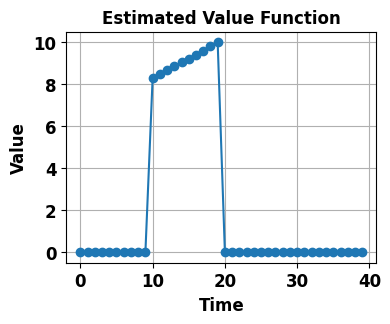

In [11]:
plt.figure(figsize=(4, 3))
plt.plot(V,'o-')
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Estimated Value Function', fontsize=12, fontweight='bold')
plt.grid()
plt.show()

### **Open question 2 (0.5 Point)**

Plot the TD error over the whole learning process. Please also analyze the obtained plot to see wether it meets the expectation.

**Hint:** Examine how the TD-error changes across iterations in the heatmap and line plot—Do specific points within each trial show a consistent decrease or increase in TD-error, and what might this indicate about the model’s ability to predict expected outcomes as learning progresses?

<span style="color:red">Your answer: The TD-error at the begining of the iterations is at 19 but by iteration 20 it has decreased to 9. The decrease in TD-error in this period shows that the model is learning and the difference between current value estimate and updated reward is decreasing. This makes sense because by iteration 20 the reward has been delivered. Furthermore, in the line plot we see with the first iteration the peak of TD-error is high and it decreases as the iterations go on till iteration -9. This is due to the increase in estimated value function at iteration 9. The we see the line plot amplitude starts to increase after -10 till -40.    </span>


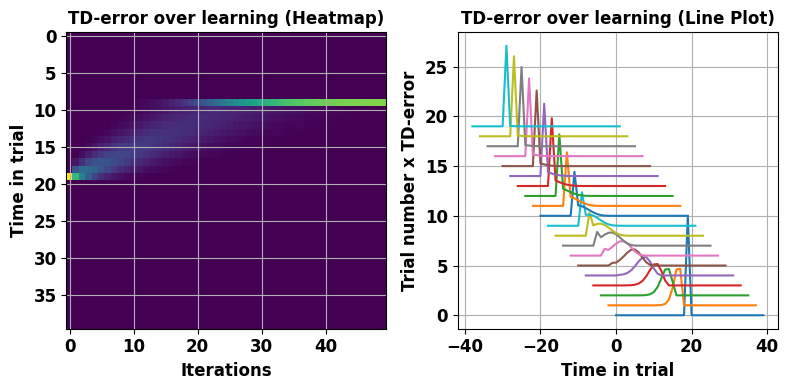

In [12]:
plt.figure(figsize=(8, 4))
# First plot: TD-error heatmap
plt.subplot(1, 2, 1)
indx = np.arange(0, n_trials, 400)
plt.imshow(TD_error[:, indx], aspect='auto')
plt.xlabel('Iterations', fontsize=12, fontweight='bold')
plt.ylabel('Time in trial', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('TD-error over learning (Heatmap)', fontsize=12, fontweight='bold')
plt.grid()

# Second plot: TD-error over time in trial for different trials
plt.subplot(1, 2, 2)
indx = np.arange(0, n_trials, 1000)
for ii, iindx in enumerate(indx):
    plt.plot(np.arange(n_steps) - ii * 2, TD_error[:, iindx] + ii)

plt.xlabel('Time in trial', fontsize=12, fontweight='bold')
plt.ylabel('Trial number x TD-error', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('TD-error over learning (Line Plot)', fontsize=12, fontweight='bold')
plt.grid()

plt.tight_layout()
plt.show()


## 1.5 TD-Learning for State-Value Estimation with Probabilistic Rewards

In this session, you are asked to implement TD-learning in the context of probabilistic rewards. Determine a probability of reward delivery ($P(r) < 1$) and on each trial randomly determine whether or not to present a reward on that trial. Note that we keep reward magnitude constant.

### **Implement Learning process (1 point)**

In [ ]:
# define the reward probability
reward_probability = 0.8

In [ ]:
V, TD_error = initialize_values(n_steps, n_trials)

for n in range(n_trials):
    state = 0
    for t in range(n_steps):
        # please implement the reward delivery process with certain probability
        # remeber to store all delivered reward magnitudes using rr
        # codes are no more than 4 lines using np.random, if...else..., and env.define_reward(..,..)
        # YOUR CODE HERE
        raise NotImplementedError()

        next_state, reward = env.get_outcome(state)
        is_delay = env.state_dict[state][0]

        update_value_and_td_error(state, reward, next_state, V, gamma, alpha, TD_error, n, is_delay)

        state = next_state

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(V,'o-')
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Estimated Value Function', fontsize=12, fontweight='bold')
plt.grid()
plt.show()

### **Open Question 3 (0.5 Point)**

Plot the TD error over the whole learning process. Please also analyze the obtained plot to see wether it meets the expectation.

**Hint:** For analysis, please mainly focus on the different parts from the results in 1.4, and analyze the corresponding reasons.

<span style="color:red">Your answer:</span>

In [ ]:
plt.figure(figsize=(8, 4))
# First plot: TD-error heatmap
plt.subplot(1, 2, 1)
indx = np.arange(0, n_trials, 400)
plt.imshow(TD_error[:, indx], aspect='auto')
plt.xlabel('Iterations', fontsize=12, fontweight='bold')
plt.ylabel('Time in trial', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('TD-error over learning (Heatmap)', fontsize=12, fontweight='bold')
plt.grid()

# Second plot: TD-error over time in trial for different trials
plt.subplot(1, 2, 2)
indx = np.arange(0, n_trials, 1000)
for ii, iindx in enumerate(indx):
    plt.plot(np.arange(n_steps) - ii * 2, TD_error[:, iindx] + ii)

plt.xlabel('Time in trial', fontsize=12, fontweight='bold')
plt.ylabel('Trial number x TD-error', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('TD-error over learning (Line Plot)', fontsize=12, fontweight='bold')
plt.grid()

plt.tight_layout()
plt.show()

## 1.6 TD-Learning for State-Value Estimation with Variable Delays

In this session, you are asked to implement TD-learning in the context of rewards presented at variable delays since **CS**. Use a set of discrete times since CS. On each trial, randomly select the delay between **CS** and **US**.

### **Implement Learning process (1 point)**

In [ ]:
reward_times = np.arange(10,20,1)
reward_probability = 1

In [ ]:
env = classical_conditioning(n_steps)
V, TD_error = initialize_values(n_steps, n_trials)

for n in range(n_trials):
    state = 0
    # please implement the reward delivery process with different delay time
    # codes are no more than 5 lines using if...else..., np.random, and env.define_reward(..,..)
    # YOUR CODE HERE
    raise NotImplementedError()

    for t in range(n_steps):
        next_state, reward = env.get_outcome(state)
        is_delay  = env.state_dict[state][0]
        update_value_and_td_error(state, reward, next_state, V, gamma, alpha, TD_error, n, is_delay)
        state = next_state

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(V,'o-')
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Estimated Value Function', fontsize=12, fontweight='bold')
plt.grid()
plt.show()

### **Open question 4 (0.5 Point)**

Plot the TD error over the whole learning process. Please also analyze the obtained plot to see wether it meets the expectation.

**Hint:** For analysis, please mainly focus on the different parts from the results in 1.4, and analyze the corresponding reasons.

<span style="color:red">Your answer:</span>

In [ ]:
plt.figure(figsize=(8, 4))
# First plot: TD-error heatmap
plt.subplot(1, 2, 1)
indx = np.arange(0, n_trials, 400)
plt.imshow(TD_error[:, indx], aspect='auto')
plt.xlabel('Iterations', fontsize=12, fontweight='bold')
plt.ylabel('Time in trial', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('TD-error over learning (Heatmap)', fontsize=12, fontweight='bold')
plt.grid()

# Second plot: TD-error over time in trial for different trials
plt.subplot(1, 2, 2)
indx = np.arange(0, n_trials, 1000)
for ii, iindx in enumerate(indx):
    plt.plot(np.arange(n_steps) - ii * 2, TD_error[:, iindx] + ii)

plt.xlabel('Time in trial', fontsize=12, fontweight='bold')
plt.ylabel('Trial number x TD-error', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('TD-error over learning (Line Plot)', fontsize=12, fontweight='bold')
plt.grid()

plt.tight_layout()
plt.show()

# 2. Multi-armed Bandit (5 Points)

## 2.1 Introduction of Multi-armed Bandit

Consider a learning problem where you repeatedly choose among
$k$ different actions. Each choice results in a reward—a numerical value where higher values are better. The objective is to maximize the total reward over a fixed time, such as 1000 selections. This is known as the **k-armed bandit problem**, named after slot machines or "one-armed bandits." In the multi-armed bandit variation, you face multiple "machines" (or actions), but can only choose one at a time. The challenge is to decide which machine to play—or which action to take—to maximize your total payout.

For simplicity, we assume each action's reward follows a **Gaussian distribution** with an unknown mean and unit variance, referred to as the environment. The goal is to find the action with the highest average reward. To solve this optimization problem, we use an agent—an algorithm that learns from received rewards to inform its action choices.


## 2.2 Action Selection

To maximize its reward, our agent first needs a way to choose which "arm" to pull at each step. The strategy it uses for selecting actions is called a **policy**, which is denoted as $ \pi $. A simple option would be a random policy, where the agent picks an arm at random each time. However, this lacks intentionality and is unlikely to optimize the reward. Instead, we need a method to represent our beliefs about each arm’s reward potential. This is achieved with an **action-value function**, which estimates the expected cumulative reward for each action in a given state.

We define the action-value function as:

$$
Q(S_t, A_t) = \mathbb{E} \left[ \sum_{i=t+1}^{t_{\text{end}}} \gamma^{i-(t+1)} r(S_i) \right]
$$

In practice, the action-value function $ Q(S_t, A_t) $ is often represented as an array, where each action’s value is stored and updated based on experience.

With action values defined, we can now use them to develop a policy. An intuitive choice is the **greedy policy**, which always selects the action with the highest current estimated value for each state:

$$
A_t = \underset{a \in \mathcal{A}}{\arg \max} \, Q(S_t, a)
$$

This approach chooses the action that maximizes the expected value $ Q(S_t, a) $ based on the current state $ S_t $.

### **The Exploitation-Exploration Dilemma**
A purely greedy approach, however, has a significant limitation: it may easily become trapped in local optima, repeatedly selecting an action that appears best without exploring alternatives that might yield higher rewards over time. This introduces the **exploitation-exploration dilemma**:

- **Exploitation**: Choosing the action that currently seems best to maximize immediate reward.
- **Exploration**: Trying other actions to gather more information, which may reveal better options over time.

If the agent always "plays it safe" (exploitation), it risks missing out on potentially better rewards. Conversely, if it explores too much, it may fail to fully exploit the best option when it’s time to stop. Effective policies must balance these two aims to avoid getting stuck in local minima while maximizing total reward.

A simple yet effective way to balance exploitation and exploration is the **$ \epsilon $-greedy policy**. This policy extends the greedy approach by introducing a small probability $ \epsilon $ of choosing an action at random rather than sticking with the current best choice:

$$
P(A_t = a) =
        \begin{cases}
        1 - \epsilon + \frac{\epsilon}{N}    & \quad \text{if } a = \underset{a' \in \mathcal{A}}{\arg\max} \; Q(S_t, a') \\
        \frac{\epsilon}{N}        & \quad \text{otherwise}
        \end{cases}
$$

where $N$ represents the total number of available actions in the action space. In other words, with probability $ 1 - \epsilon $ (for $ \epsilon \in [0,1] $), the agent selects the greedy choice, and with probability $ \epsilon $, it selects any action at random, including the greedy option.

The $ \epsilon $-greedy policy is popular due to its simplicity and effectiveness, providing a straightforward balance between exploitation and exploration. By allowing occasional exploration, it helps the agent avoid suboptimal rewards and discover better actions over time.

### **Implement Epsilon-Greedy (2 Point)**
You are aksed to implement the epsilon-greedy algorithm for deciding which action to take from a set of possible actions given their value function and a probability $\epsilon$ of simply chosing one at random. You may find [`np.random.random`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html), [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), and [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) useful here.

Also try how changing $\epsilon$ influences our selection of the max value vs the others. At the extremes of its range (0 and 1), the $\epsilon$-greedy policy reproduces two other policies. What are they?

<span style="color:red">Your answer:</span>


In [ ]:
def epsilon_greedy(q, epsilon):
    """Epsilon-greedy policy: selects the maximum value action with probabilty
        (1-epsilon) and selects randomly with epsilon probability.

    Args:
        q (ndarray): an array of action values
        epsilon (float): probability of selecting an action randomly

    Returns:
        int: the chosen action
    """
    # write a boolean expression that determines if we should take the best action
    be_greedy = np.random.random() > epsilon

    if be_greedy:
        # write an expression for selecting the best action from the action values
        # YOUR CODE HERE
        raise NotImplementedError()
    else:
        # write an expression for selecting a random action
        # YOUR CODE HERE
        raise NotImplementedError()

    return action


# Set parameters
q = [-2, 5, 0, 1]
epsilon = 0.1

# Visualize
plot_choices(q, epsilon, epsilon_greedy)

## 2.3 Learning From Rewards

With a policy for deciding actions, the next step is to learn from each action’s outcome. One approach is to keep a complete record of all past rewards for each action and calculate their averages. However, for long episodes, this becomes computationally expensive due to storage and repeated calculations. Instead, we can use an incremental (or streaming) mean update:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{1}{n_t} \left( r(S_{t+1}) - Q(S_t, A_t) \right)
$$

where $ n_t $ is the number of times action $ A_t $ has been selected in state $ S_t $ by time $ t $. This approach updates the mean incrementally with each new reward, minimizing computational cost.

To simplify further and avoid tracking $ n_t $, we introduce a general parameter $ \alpha $, called the **learning rate**, which controls the influence of each new reward on the estimate. The update rule then becomes:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left( r(S_{t+1}) - Q(S_t, A_t) \right)
$$

This form makes the update process more flexible, with $ \alpha $ determining how much each new reward adjusts the estimated value $ Q(S_t, A_t) $.

### **Updating Action Values (0.5 Point)**
You are asked to implement the action-value update rule above. The function will take in the action-value function represented as an array $q$, the action taken, the reward received, and the learning rate, **$\alpha$**. The function will return the updated value for the selection action.

In [ ]:
def update_action_value(q, action, reward, alpha):
    """ Compute the updated action value given the learning rate and observed
    reward.

    Args:
        q (ndarray): an array of action values
        action (int): the action taken
        reward (float): the reward received for taking the action
        alpha (float): the learning rate

    Returns:
        float: the updated value for the selected action
    """

    # Write an expression for the updated action value
    # YOUR CODE HERE
    raise NotImplementedError()

    return value


# Set parameters
q = [-2, 5, 0, 1]
action = 2
print(f"Original q({action}) value = {q[action]}")

# Update action
q[action] = update_action_value(q, 2, 10, 0.01)
print(f"Updated q({action}) value = {q[action]}")

## 2.4 Training Multi-armed Bandits (2 Points)


Now that we have both a policy and a learning rule, we can combine these to solve our original multi-armed bandit task. Recall that we have some number of arms that give rewards drawn from Gaussian distributions with unknown mean and unit variance, and our goal is to find the arm with the highest mean.

In [ ]:
def multi_armed_bandit(n_arms, epsilon, alpha, n_steps):
    """ A Gaussian multi-armed bandit using an epsilon-greedy policy. For each
    action, rewards are randomly sampled from normal distribution, with a mean
    associated with that arm and unit variance.

    Args:
        n_arms (int): number of arms or actions
        epsilon (float): probability of selecting an action randomly
        alpha (float): the learning rate
        n_steps (int): number of steps to evaluate

    Returns:
        dict: a dictionary containing the action values, actions, and rewards from
        the evaluation along with the true arm parameters mu and the optimality of
        the chosen actions.
    """
    # Gaussian bandit parameters
    mu = np.random.normal(size=n_arms)

    # Evaluation and reporting state
    q = np.zeros(n_arms)
    qs = np.zeros((n_steps, n_arms))
    rewards = np.zeros(n_steps)
    actions = np.zeros(n_steps)
    optimal = np.zeros(n_steps)

    # Run the bandit
    for t in range(n_steps):

        # Choose an action
        # YOUR CODE HERE
        raise NotImplementedError()
        actions[t] = action

        # Compute rewards for all actions
        # YOUR CODE HERE
        raise NotImplementedError()

        # Observe the reward for the chosen action
        reward = all_rewards[action]
        rewards[t] = reward

        # Was it the best possible choice?
        # YOUR CODE HERE
        raise NotImplementedError()
        optimal[t] = action == optimal_action

        # Update the action value
        # YOUR CODE HERE
        raise NotImplementedError()
        qs[t] = q

    results = {
        'qs': qs,
        'actions': actions,
        'rewards': rewards,
        'mu': mu,
        'optimal': optimal
      }

    return results

We can use our multi-armed bandit method to evaluate how our epsilon-greedy policy and learning rule perform at solving the task. First we will set our environment to have 10 arms and our agent parameters to $\epsilon=0.1$ and $\alpha=0.01$. In order to get a good sense of the agent's performance, we will run the episode for 1000 steps.

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)
n_arms = 10
epsilon = 0.1
alpha = 0.01
n_steps = 1000

results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Plot for observed rewards
ax1.plot(results['rewards'])
ax1.set(title=f'Observed Reward ($\epsilon$={epsilon}, $\\alpha$={alpha})',
        xlabel='Step', ylabel='Reward')
ax1.title.set_weight('bold')
ax1.xaxis.label.set_weight('bold')
ax1.yaxis.label.set_weight('bold')
ax1.tick_params(axis='both', which='both', labelsize=10, width=2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)

# Plot for action values
ax2.plot(results['qs'])
ax2.set(title=f'Action Values ($\epsilon$={epsilon}, $\\alpha$={alpha})',
        xlabel='Step', ylabel='Value')
ax2.title.set_weight('bold')
ax2.xaxis.label.set_weight('bold')
ax2.yaxis.label.set_weight('bold')
ax2.tick_params(axis='both', which='both', labelsize=10, width=2)
ax2.spines['top'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)

# Legend for action values plot
ax2.legend(range(n_arms))
plt.grid()
plt.tight_layout()
plt.show()

Alright, we got some rewards that are kind of all over the place, but the agent seemed to settle in on the first arm as the preferred choice of action relatively quickly. Let's see how well we did at recovering the true means of the Gaussian random variables behind the arms.

### **Comparison Between the Estimated Means and Ground Truth**

Now, let us compare the estimated values of means and the ground truth by running the following codes. We can see that the algorithm finds a very good estimate for action 0, but most if the others are not great. In fact, we can see the effect of the local maxima trap at work -- the greedy part of our algorithm locked onto action 0, which is actually the 2nd best choice to action 6. Since these are the means of Gaussian random variables, we can see that the overlap between the two would be quite high, so even if we did explore action 6, we may draw a sample that is still lower than our estimate for action 0.


In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(results['mu'], '-o', label='latent')
plt.plot(results['qs'][-1], '-o', label='learned')
plt.xlabel('action', fontsize=12, fontweight='bold')
plt.ylabel('value', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title(f'$\epsilon$={epsilon}, $\\alpha$={alpha}', fontsize=12, fontweight='bold')
plt.grid()
plt.show()

We can further try different combination of $\epsilon$ (exploitation-exploration tradeoff) and $\alpha$ to see if we can obtain better results. Note that due to the stochastic nature of both our rewards and our policy, a single trial run isn't sufficient to give us this information-which combination is better. Let's run mulitple trials and compare the average performance.


### **Explore $\epsilon$ (0.5 Point)**


First we will look at different values for $\epsilon \in [0.0, 0.1, 0.2]$ to a fixed $\alpha=0.1$. We will run 200 trials as a nice balance between speed and accuracy. Please run the following codes and analyze the results.

**Hint:** For analysis, please identify the values of $\epsilon$ that optimize performance in the initial stage of learning and those that enhance performance in later stages, providing a comparative insight across the learning progression.

<span style="color:red">Your answer:</span>

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

epsilons = [0.0, 0.1, 0.2]
alpha = 0.1
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, epsilon in enumerate(epsilons):
    for n in range(n_trials):
        results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
        trial_rewards[i, n] = results['rewards']
        trial_optimal[i, n] = results['optimal']

labels = [f'$\epsilon$={e}' for e in epsilons]
fixed = f'$\\alpha$={alpha}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

### **Explore learnign rate (0.5 Point)**
We can also do the same for the learning rates. We will evaluate $\alpha \in [0.01, 0.1, 1.0]$ to a fixed $\epsilon=0.1$. Please run the following codes and analyze the results.

**Hint:** You can compare the results for three different $\alpha$ values across the entire learning process, highlighting which value consistently yields the best performance and which demonstrates the least favorable outcomes.

<span style="color:red">Your answer:</span>

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

epsilon = 0.1
alphas = [0.01, 0.1, 1.0]
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, alpha in enumerate(alphas):
    for n in range(n_trials):
        results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
        trial_rewards[i, n] = results['rewards']
        trial_optimal[i, n] = results['optimal']

labels = [f'$\\alpha$={a}' for a in alphas]
fixed = f'$\epsilon$={epsilon}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)